In [1]:
import numpy as np
import pandas as pd
import cmdstanpy 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import os
import json
from utils.random import simulate_ANN_RDM
from Utils.utils import hdi
from scipy.stats import gaussian_kde
import ipywidgets as widgets

ModuleNotFoundError: No module named 'Utils'

In [3]:
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["pdf.use14corefonts"] = True

In [4]:
root = "./"
plots_root = root + "Plots/Parameter Recovery"
datasets_root = root + "Datasets/"
behavioural_data_root = root +  "behavioral_data/selected_data/" 
stan_files_root = root +  "stan files/" 
saved_models_root = root + "stan_results/Parameter Recovery"
dataset_path = datasets_root + "FastText_FC.csv"

In [ ]:
number_of_participants = 4
number_of_parameters = 7
number_of_iteration = 4
n_trials = 100

## Funtions

In [37]:
def generate_parameter_set(number_of_participants,  number_of_parameters):
    # Prior ranges for the simulator
    # alpha ~ U(0.1, 5.0)
    # b ~ U(0.1, 5.0)
    # k_1 ~ U(0.1, 5.0)  # relative start point
    # k_2 ~ U(0.1, 5.0)
    # threshold_word ~ U(2.0, 8.0)
    # threshold_nonword ~ U(2.0, 8.0)
    # ndt ~ U(0.01, 2)

    return np.random.uniform(low=(0.1, 0.1, 0.1, 0.1, 2.0, 2.0, 0.01),
                                      high=(5.0, 5.0, 5.0, 5.0, 8.0, 8.0, 1.0),
                                      size=(number_of_participants, number_of_parameters))

In [5]:
# set sampling parameters
n_iter = 500
n_warmup = int(n_iter/2)
n_sample = int(n_iter/2)
n_chains = 2

threshold_priors = [0, 1, 1, 1]          # For all models with LBA
ndt_priors = [0, 1, 1, 1];               # For models wtihout non-decision time modulation
g_priors = [-2, 1, 0, 1]                 # For models wtih non-decision time modulation
m_priors = [0, 0.5, 0, 1]                # For models wtih non-decision time modulation
drift_priors = [1, 2, 1, 1]              # For models without drift mapping functions (non ANN-EAM models)
alpha_priors = [0, 1, 1, 1]              # For models with drift mapping functions
b_priors = [0, 1, 1, 1]                  # For models with drift mapping functions with asymptote modulation and linear models
k_priors = [2, 1, 1, 1]                  # For models with sigmoid drift mapping functions (ANN-EAM models)

def get_stan_parameters(generated_df):
    N = len(generated_df)                                                    # For all models
    participant = generated_df["participant_id"].to_numpy()                     # For all models
    p = generated_df.loc[:, ["word_prob", "non_word_prob"]].to_numpy()       # predicted probabilites of words and non-words, for ANN-EAM models
    frequency = generated_df["zipf"].to_numpy().astype(int)                  # zipf values, for models with non-decision time or drift modulation
    frequencyCondition = generated_df["category"].replace(["HF", "LF", "NW"], [1, 2, 3]).to_numpy() # For models with conditional drift
    response = generated_df["response"].to_numpy().astype(int)               # for all models
    rt = generated_df["rt"].to_numpy()                                       # for all models
    minRT = generated_df["minRT"].to_numpy()                                 # for all models
    RTbound = 0.1                                                              # for all models
    Number_Of_Participants = len(set(behavioral_df["participant_id"]))

    # define input for the model
    data_dict = {"N": N,
                 "L": Number_Of_Participants,
                 "participant": participant,
                 "response": response,
                 "rt": rt,
                 "minRT": minRT,
                 "RTbound": RTbound,
                 "frequency": frequency,
                 "frequencyCondition": frequencyCondition,
                 "threshold_priors": threshold_priors,
                 "ndt_priors": ndt_priors,
                 "g_priors": g_priors,
                 "m_priors": m_priors,
                 "drift_priors": drift_priors,
                 "p": p,
                 "alpha_priors": alpha_priors,
                 "b_priors": b_priors,
                 "k_priors": k_priors,
                 }
    return data_dict

In [6]:
def save_results_to_csv(fit, simulation_number):
    columns = {"participant_id":-1,
           "mean_k_1":-1, "HDI_k_1_top":-1, "HDI_k_1_bottom":-1, "real_k_1":-1, "median_k_1":-1,
           "mean_k_2":-1, "HDI_k_2_top":-1, "HDI_k_2_bottom":-1, "real_k_2":-1, "median_k_2":-1,
           "mean_alpha":-1, "HDI_alpha_top": -1, "HDI_alpha_bottom":-1, "real_alpha":-1, "median_alpha":-1,
           "mean_b":-1, "HDI_b_top":-1, "HDI_b_bottom":-1, "real_b":-1, "median_b":-1,
           "mean_ndt":-1, "HDI_ndt_top":-1, "HDI_ndt_bottom":-1, "real_ndt":-1, "median_ndt":-1,
           "mean_threshold_word":-1, "HDI_threshold_word_top":-1, "HDI_threshold_word_bottom":-1, 
           "real_threshold_word":-1, "median_threshold_word":-1,
           "mean_threshold_nonword":-1, "HDI_threshold_nonword_top":-1, "HDI_threshold_nonword_bottom":-1,
           "real_threshold_nonword":-1, "median_threshold_nonword":-1}
    
    recoverd_df_individual = pd.DataFrame([], columns=columns.keys())
    recoverd_df_group = pd.DataFrame([])
    
    hdi_vals = hdi(fit.stan_variables()["transf_mu_k_1"])
    recoverd_df_group["transf_mu_k_1_bottom"] = [hdi_vals[0]]
    recoverd_df_group["transf_mu_k_1_top"] = [hdi_vals[1]]
    
    hdi_vals = hdi(fit.stan_variables()["transf_mu_k_2"])
    recoverd_df_group["transf_mu_k_2_bottom"] = [hdi_vals[0]]
    recoverd_df_group["transf_mu_k_2_top"] = [hdi_vals[1]]
  
    hdi_vals = hdi(fit.stan_variables()["transf_mu_alpha"])
    recoverd_df_group["transf_mu_alpha_bottom"] = [hdi_vals[0]]
    recoverd_df_group["transf_mu_alpha_top"] = [hdi_vals[1]]
    
    hdi_vals = hdi(fit.stan_variables()["transf_mu_b"])
    recoverd_df_group["transf_mu_b_bottom"] = [hdi_vals[0]]
    recoverd_df_group["transf_mu_b_top"] = [hdi_vals[1]]
    
    hdi_vals = hdi(fit.stan_variables()["transf_mu_threshold_word"])
    recoverd_df_group["transf_mu_threshold_word_bottom"] = [hdi_vals[0]]
    recoverd_df_group["transf_mu_threshold_word_top"] = [hdi_vals[1]]
    
    hdi_vals = hdi(fit.stan_variables()["transf_mu_threshold_nonword"])
    recoverd_df_group["transf_mu_threshold_nonword_bottom"] = [hdi_vals[0]]
    recoverd_df_group["transf_mu_threshold_nonword_top"] = [hdi_vals[1]]
    
    hdi_vals = hdi(fit.stan_variables()["transf_mu_ndt"])
    recoverd_df_group["transf_mu_ndt_bottom"] = [hdi_vals[0]] 
    recoverd_df_group["transf_mu_ndt_top"] = [hdi_vals[1]]
    
    recoverd_df_group['simulation_number']=[simulation_number]
        
    for id in behavioral_df.participant_id.unique():
        columns.clear()
        participant_df = (behavioral_df.loc[behavioral_df["participant_id"]==id]).reset_index(drop=True)
        columns["participant_id"] = id

        columns["mean_k_1"] = fit.stan_variables()["k_1_sbj"][:, id-1].mean()
        columns["median_k_1"] = np.median(fit.stan_variables()["k_1_sbj"][:, id-1])
        columns["real_k_1"] = participant_df.loc[0, "k_1"]
        columns["HDI_k_1_bottom"], columns["HDI_k_1_top"] = hdi(fit.stan_variables()["k_1_sbj"][:, id-1])

        columns["mean_k_2"] = fit.stan_variables()["k_2_sbj"][:, id-1].mean()
        columns["median_k_2"] = np.median(fit.stan_variables()["k_2_sbj"][:, id-1])
        columns["real_k_2"] = participant_df.loc[0, "k_2"]
        columns["HDI_k_2_bottom"], columns["HDI_k_2_top"] = hdi(fit.stan_variables()["k_2_sbj"][:, id-1])

        columns["mean_alpha"] = fit.stan_variables()["alpha_sbj"][:, id-1].mean()
        columns["median_alpha"] = np.median(fit.stan_variables()["alpha_sbj"][:, id-1])
        columns["real_alpha"] = participant_df.loc[0, "alpha"]
        columns["HDI_alpha_bottom"], columns["HDI_alpha_top"] = hdi(fit.stan_variables()["alpha_sbj"][:, id-1])

        columns["mean_b"] = fit.stan_variables()["b_sbj"][:, id-1].mean()
        columns["median_b"] = np.median(fit.stan_variables()["b_sbj"][:, id-1])
        columns["real_b"] = participant_df.loc[0, "b"]
        columns["HDI_b_bottom"], columns["HDI_b_top"] = hdi(fit.stan_variables()["b_sbj"][:, id-1])

        columns["mean_ndt"] = fit.stan_variables()["ndt_sbj"][:, id-1].mean()
        columns["median_ndt"] = np.median(fit.stan_variables()["ndt_sbj"][:, id-1])
        columns["real_ndt"] = participant_df.loc[0, "ndt"]
        columns["HDI_ndt_bottom"], columns["HDI_ndt_top"] = hdi(fit.stan_variables()["ndt_sbj"][:, id-1])

        columns["mean_threshold_word"] = fit.stan_variables()["threshold_sbj_word"][:, id-1].mean()
        columns["median_threshold_word"] = np.median(fit.stan_variables()["threshold_sbj_word"][:, id-1])
        columns["real_threshold_word"] = participant_df.loc[0, "threshold_word"]
        columns["HDI_threshold_word_bottom"], columns["HDI_threshold_word_top"] = hdi(fit.stan_variables()["threshold_sbj_word"][:, id-1])

        columns["mean_threshold_nonword"] = fit.stan_variables()["threshold_sbj_nonword"][:, id-1].mean()
        columns["median_threshold_nonword"] = np.median(fit.stan_variables()["threshold_sbj_nonword"][:, id-1])
        columns["real_threshold_nonword"] = participant_df.loc[0, "threshold_nonword"]
        columns["HDI_threshold_nonword_bottom"], columns["HDI_threshold_nonword_top"] = hdi(fit.stan_variables()["threshold_sbj_word"][:, id-1])
        
        recoverd_df_individual = pd.concat([recoverd_df_individual, pd.DataFrame(columns, index=[id-1])])
    
    recoverd_df_individual["simulation_number"] = [i]*len(recoverd_df_individual)
    
    output_individual_path='recovery_individual_results.csv'
    recoverd_df_individual.to_csv(output_individual_path, mode='a',
                                  header=not os.path.exists(output_individual_path), index=False)
    output_group_path='recovery_group_results.csv'
    recoverd_df_group.to_csv(output_group_path, mode='a',
                             header=not os.path.exists(output_group_path), index=False)

## Prepare data

In [7]:
word_nword_df = pd.read_csv(dataset_path, header=None,
                            names =["string", "freq",  "label", "zipf",
                                    "category", "word_prob", "non_word_prob"])

In [8]:
rdm_model = cmdstanpy.CmdStanModel(model_name="ANN-RDM",
                                   stan_file="stan files/ANN-RDM/sigmoid_am.stan")

In [9]:
for i in range(number_of_iteration):
    print(f"Iteration {i} Started")
    parameters_set = generate_parameter_set(number_of_participants,
                                           number_of_parameters)
    behavioral_df = simulate_ANN_RDM(n_trials=n_trials, trials_info_df=word_nword_df,
                                         parameters_set=parameters_set)
    behavioral_df = behavioral_df.dropna()
    stan_parameters = get_stan_parameters(behavioral_df)
    fit = rdm_model.sample(data=stan_parameters,
                       iter_sampling=n_sample, 
                       iter_warmup=n_warmup,
                       chains=n_chains,
                       show_console=False)
    save_results_to_csv(fit, i)
    print(f"Iteration {i} Finished") 

Iteration 0 Started


00:08:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

00:09:23 - cmdstanpy - INFO - CmdStan done processing.
00:09:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: tmp0zhn4s3p_model_namespace::log_prob: drift_word_t[204] is nan, but must be greater than or equal to 0.000000 (in 'C:/Users/Arash/AppData/Local/Temp/tmp1nj3g9vo/tmp0zhn4s3p.stan', line 111, column 4 to column 36)
Exception: tmp0zhn4s3p_model_namespace::log_prob: drift_word_t[4] is nan, but must be greater than or equal to 0.000000 (in 'C:/Users/Arash/AppData/Local/Temp/tmp1nj3g9vo/tmp0zhn4s3p.stan', line 111, column 4 to column 36)
	Exception: tmp0zhn4s3p_model_namespace::log_prob: drift_word_t[285] is nan, but must be greater than or equal to 0.000000 (in 'C:/Users/Arash/AppData/Local/Temp/tmp1nj3g9vo/tmp0zhn4s3p.stan', line 111, column 4 to column 36)
Consider re-running with show_console=True if the above output is unclear!



Iteration 0 Finished
Iteration 1 Started


00:09:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

00:11:09 - cmdstanpy - INFO - CmdStan done processing.
00:11:09 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 14 divergent transitions (5.6%)
	Chain 2 had 1 divergent transitions (0.4%)
	Use function "diagnose()" to see further information.



Iteration 1 Finished
Iteration 2 Started


00:11:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

00:13:19 - cmdstanpy - INFO - CmdStan done processing.
00:13:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: tmp0zhn4s3p_model_namespace::log_prob: drift_word_t[4] is nan, but must be greater than or equal to 0.000000 (in 'C:/Users/Arash/AppData/Local/Temp/tmp1nj3g9vo/tmp0zhn4s3p.stan', line 111, column 4 to column 36)
	Exception: tmp0zhn4s3p_model_namespace::log_prob: drift_nonword_t[1] is nan, but must be greater than or equal to 0.000000 (in 'C:/Users/Arash/AppData/Local/Temp/tmp1nj3g9vo/tmp0zhn4s3p.stan', line 112, column 4 to column 39)
Exception: Exception: Exception: Phi: x is nan, but must be not nan! (in 'C:/Users/Arash/AppData/Local/Temp/tmp1nj3g9vo/tmp0zhn4s3p.stan', line 14, column 8 to column 72) (in 'C:/Users/Arash/AppData/Local/Temp/tmp1nj3g9vo/tmp0zhn4s3p.stan', line 31, column 20 to column 74) (in 'C:/Users/Arash/AppData/Local/Temp/tmp1nj3g9vo/tmp0zhn4s3p.stan', line 187, column 4 to column 91)
Consider re-running with show_console=True if the ab


Iteration 2 Finished
Iteration 3 Started


00:13:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

00:15:32 - cmdstanpy - INFO - CmdStan done processing.
00:15:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: tmp0zhn4s3p_model_namespace::log_prob: drift_word_t[1] is nan, but must be greater than or equal to 0.000000 (in 'C:/Users/Arash/AppData/Local/Temp/tmp1nj3g9vo/tmp0zhn4s3p.stan', line 111, column 4 to column 36)
	Exception: tmp0zhn4s3p_model_namespace::log_prob: drift_word_t[1] is nan, but must be greater than or equal to 0.000000 (in 'C:/Users/Arash/AppData/Local/Temp/tmp1nj3g9vo/tmp0zhn4s3p.stan', line 111, column 4 to column 36)
	Exception: tmp0zhn4s3p_model_namespace::log_prob: drift_word_t[1] is nan, but must be greater than or equal to 0.000000 (in 'C:/Users/Arash/AppData/Local/Temp/tmp1nj3g9vo/tmp0zhn4s3p.stan', line 111, column 4 to column 36)
	Exception: tmp0zhn4s3p_model_namespace::log_prob: drift_word_t[1] is nan, but must be greater than or equal to 0.000000 (in 'C:/Users/Arash/AppData/Local/Temp/tmp1nj3g9vo/tmp0zhn4s3p.stan', line 111, column 


Iteration 3 Finished


## Particpants parameter recovery

In [7]:
parameters = ["k_1", "k_2", "alpha", "b", "threshold_word",  "threshold_nonword", "ndt"] 

### Indiviual Level Parameter Recovery

In [8]:
recovery_individual_df = pd.read_csv("recovery_individual_results.csv", header=0)
recovery_group_df = pd.read_csv("recovery_group_results.csv", header=0)

### mean

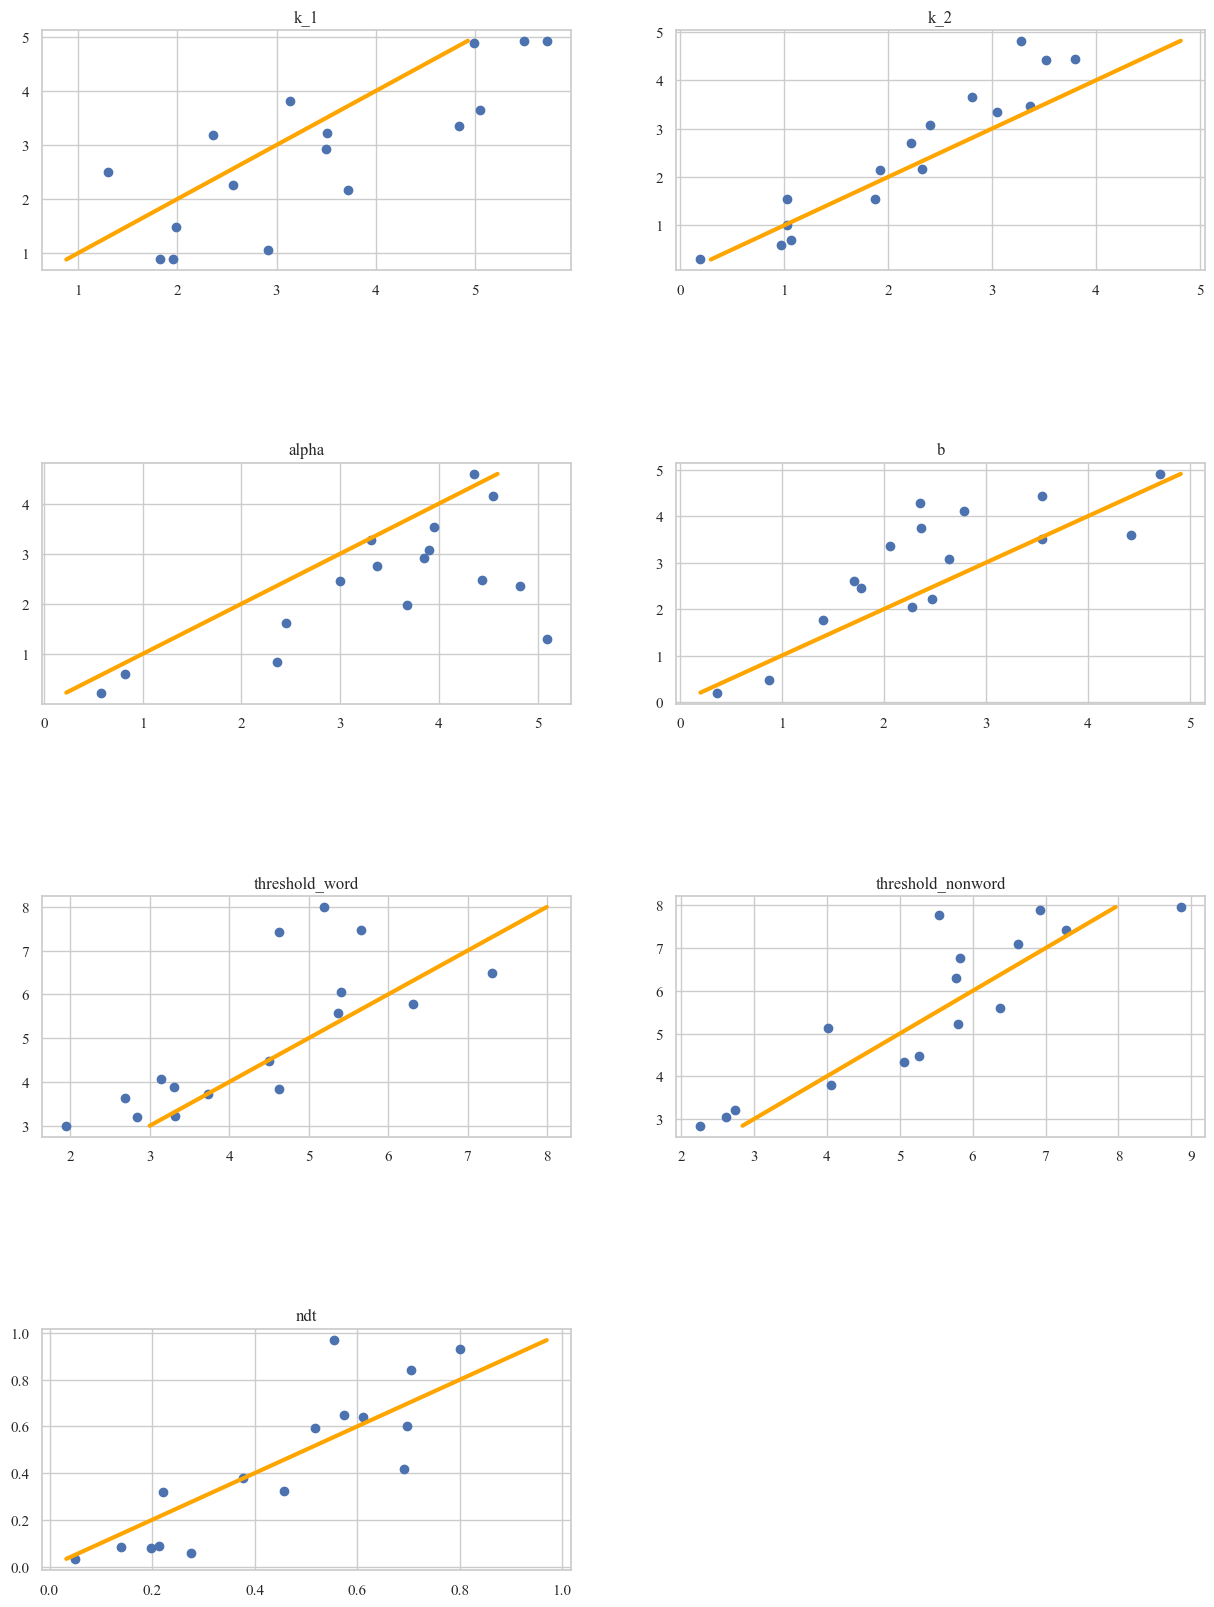

In [58]:
fig, axes = plt.subplots(4,2, figsize=(15,20))
plt.subplots_adjust(wspace=0.2, hspace=0.8)
raveled_axes = axes.ravel()

for index, parameter in enumerate(parameters):      
    posterior = recovery_individual_df["mean_"+parameter]
    true = recovery_individual_df["real_"+parameter]
    raveled_axes[index].scatter(posterior, true)
    raveled_axes[index].set_title(parameter)
    tempx = np.linspace(recovery_individual_df["real_" + parameter].min(), recovery_individual_df["real_" + parameter].max(), num=100)
    recoverline = raveled_axes[index].plot(tempx, tempx)
    plt.setp(recoverline, linewidth=3, color="orange")

fig.delaxes(axes[3][1])

### Median 

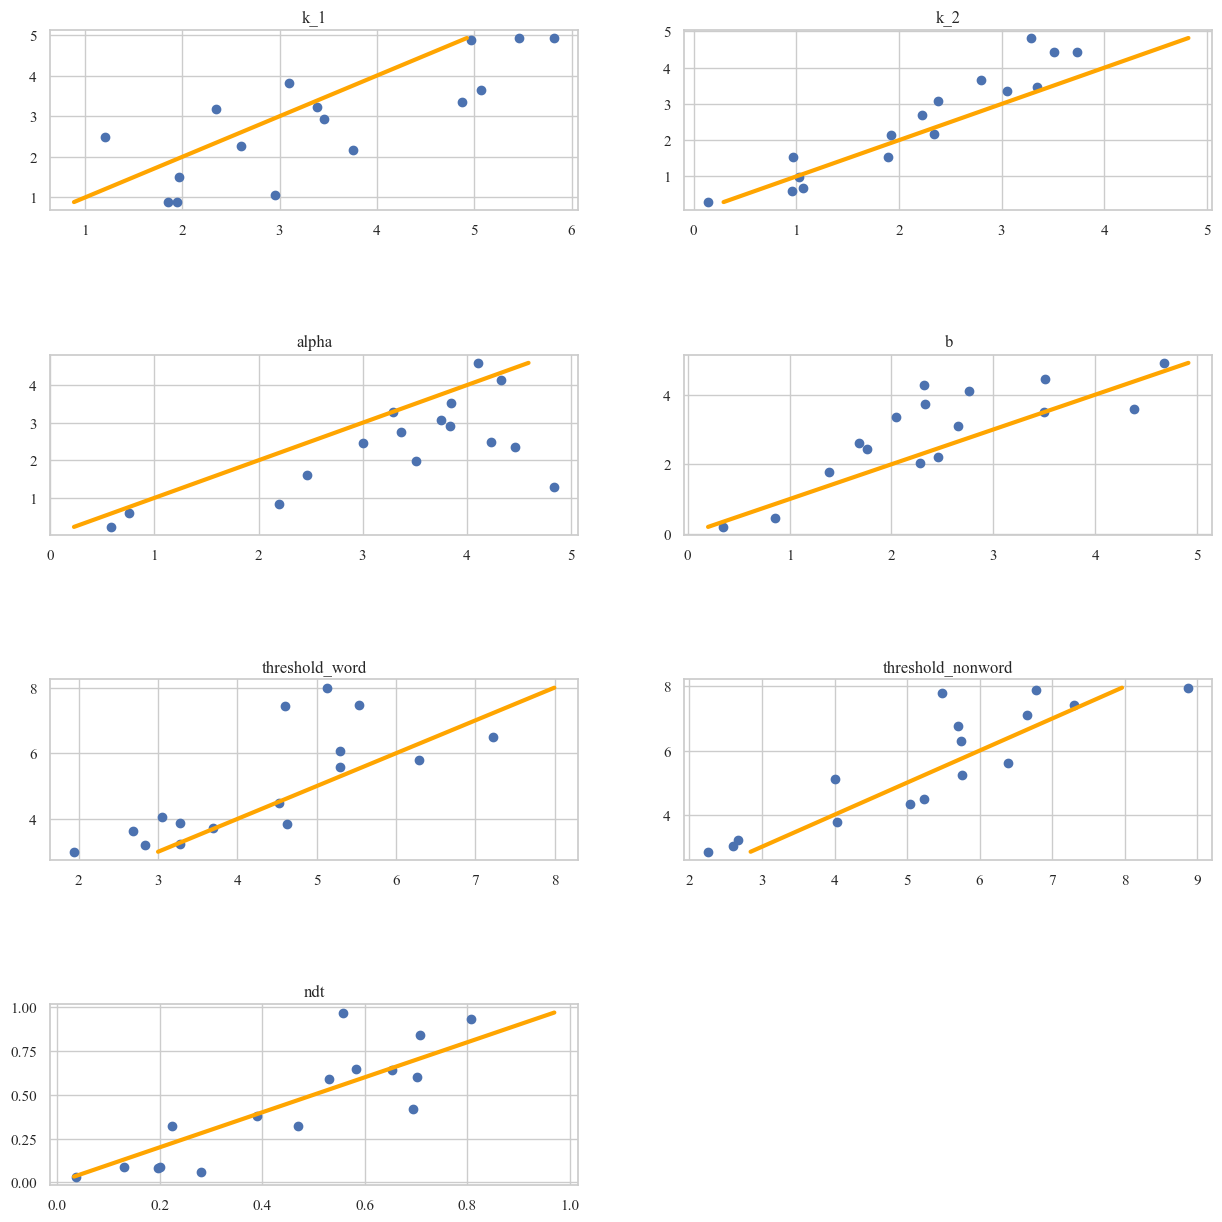

In [57]:
fig, axes = plt.subplots(4, 2, figsize=(15,15))
plt.subplots_adjust(wspace=0.2, hspace=0.8)
raveled_axes = axes.ravel()

for index, parameter in enumerate(parameters):      
    posterior = recovery_individual_df["median_"+parameter]
    true = recovery_individual_df["real_"+parameter]
    raveled_axes[index].scatter(posterior, true)
    raveled_axes[index].set_title(parameter)
    tempx = np.linspace(recovery_individual_df["real_" + parameter].min(), recovery_individual_df["real_" + parameter].max(), num=100)
    recoverline = raveled_axes[index].plot(tempx, tempx)
    plt.setp(recoverline, linewidth=3, color="orange")

fig.delaxes(axes[3][1])

### Group level parameter recovery

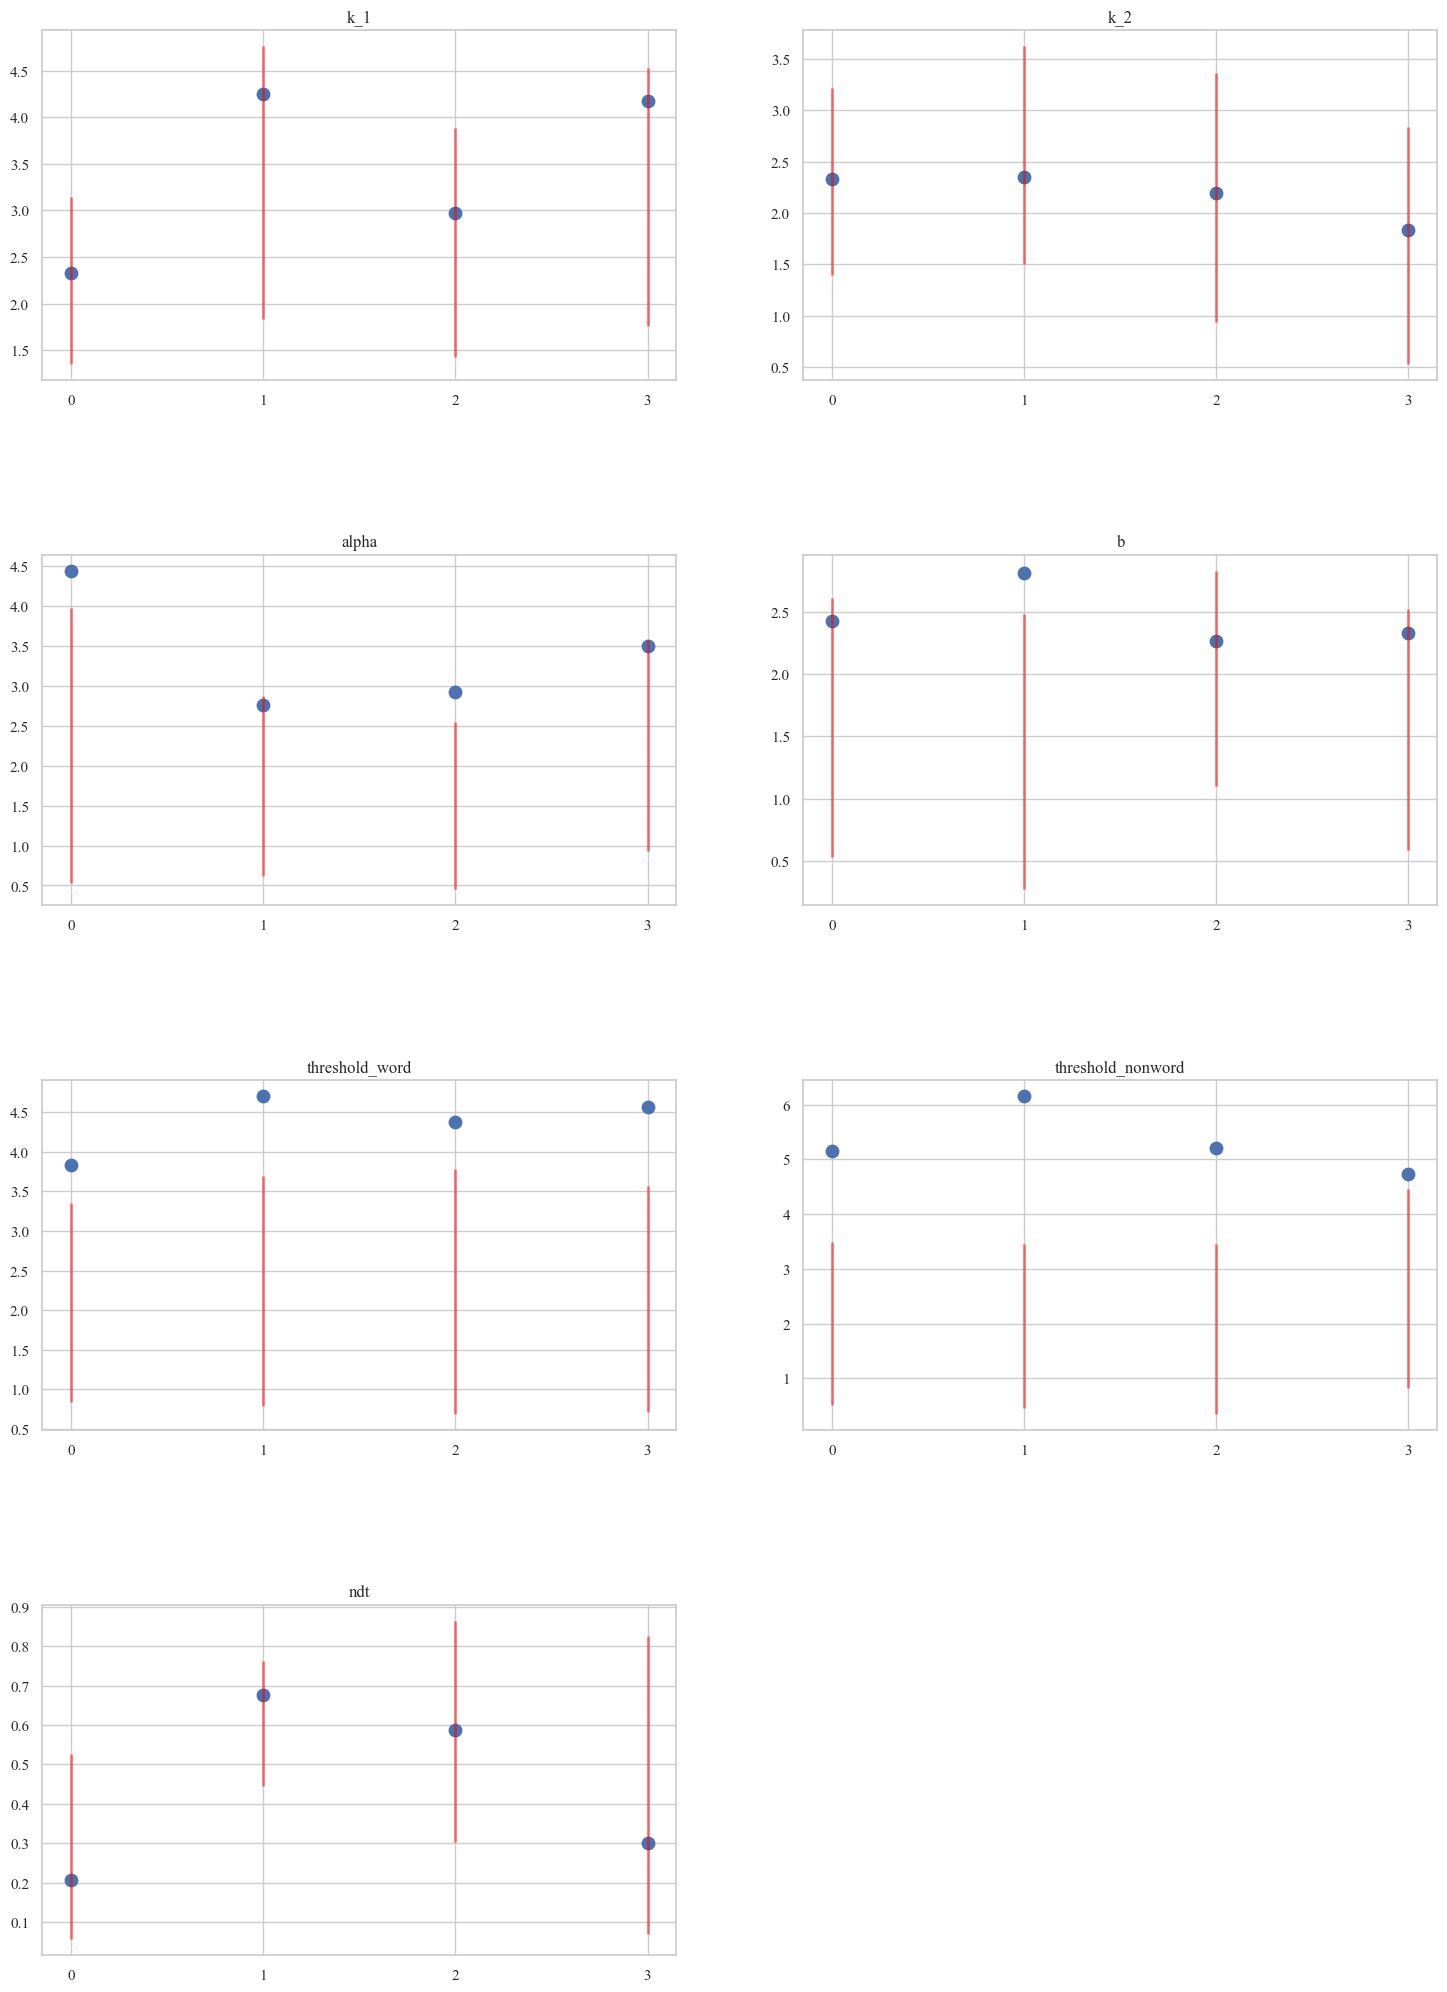

In [49]:
fig, axes = plt.subplots(4, 2, figsize=(18,25))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
raveled_axes = axes.ravel()


for index, parameter in enumerate(parameters):
    
    raveled_axes[index].scatter(recovery_group_df["simulation_number"].unique().astype("str"),
                                recovery_individual_df.groupby("simulation_number").mean()["mean_"+parameter],
                               s=80)
    raveled_axes[index].vlines(recovery_group_df["simulation_number"].unique(),
                               recovery_group_df["transf_mu_"+parameter+"_bottom"],
                               recovery_group_df["transf_mu_"+parameter+"_top"],
                               linewidth=2, colors='red', alpha=0.5)
    raveled_axes[index].set_title(parameter)

fig.delaxes(axes[3][1])